In [1]:
!pip install bayesian_optimization --quiet
!pip install ppscore --quiet
!pip install -q catboost

     |████████████████████████████████| 65.8MB 65kB/s 


In [2]:
%cd drive/MyDrive/buyer_time_pred/

/content/drive/MyDrive/buyer_time_pred


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import style
style.use('dark_background')
import ppscore as pps
#REgressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from catboost import CatBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
#from catboost import CatBoostRegressor
#Evalution Metrix
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error

In [43]:
df_train = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Test.csv')
sub = pd.read_csv('/content/drive/MyDrive/buyer_time_pred/ParticipantData_BTPC/Sample Submission.csv')

In [44]:
df_train.drop('session_id', axis=1, inplace=True)
df_test.drop('session_id', axis=1, inplace=True)

In [6]:
print(df_train.shape, df_test.shape)

(5429, 8) (2327, 7)


In [7]:
df_train.describe()

,session_number,purchased,added_in_cart,checked_out,time_spent
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,1072.835329,0.159145,0.162092,0.017499,663.194292
std,1436.351474,0.365845,0.368570,0.131132,1713.671664
min,11.000000,0.000000,0.000000,0.000000,14.400000
25%,121.000000,0.000000,0.000000,0.000000,22.699000
50%,517.000000,0.000000,0.000000,0.000000,98.312000
75%,1397.000000,0.000000,0.000000,0.000000,600.463000
max,7722.000000,1.000000,1.000000,1.000000,38494.025000


## EDA

In [8]:
df_train.head()

,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


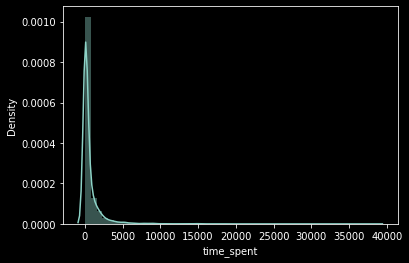

In [9]:
sns.distplot(df_train.time_spent);

In [10]:
cat_feats = ['purchased','added_in_cart','checked_out']
num_feats = ['session_number']

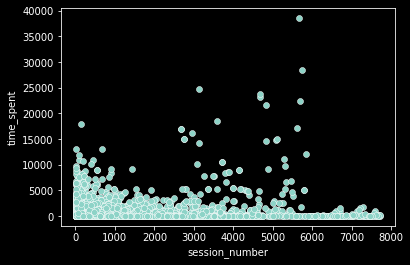

In [11]:
sns.scatterplot(x='session_number', y='time_spent', data=df_train);

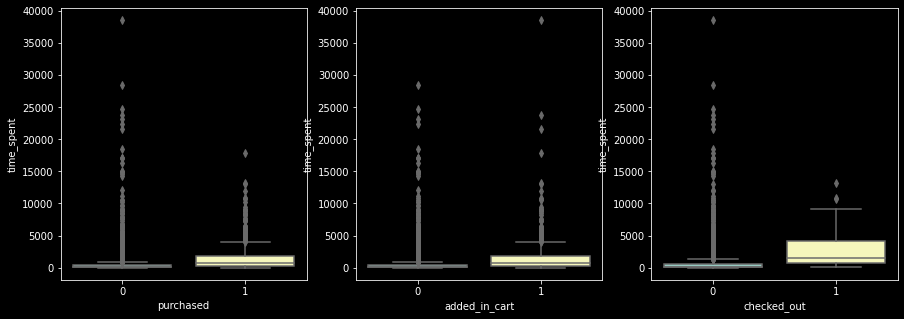

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for catfeat, subplot in zip(cat_feats, ax.flatten()):
    sns.boxplot(x=catfeat, y='time_spent', data=df_train, ax=subplot)

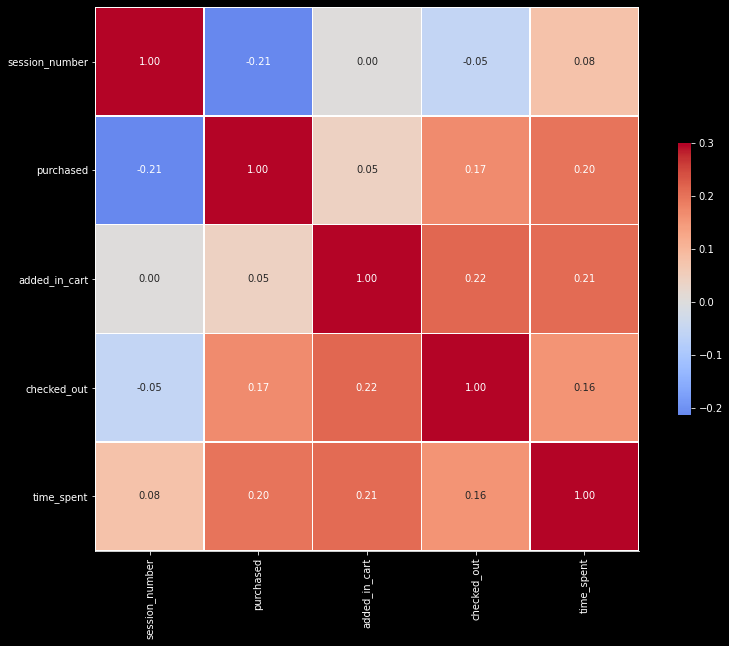

In [13]:
corr = df_train.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()

## Outlier Rem

In [45]:
#upper_lim = df_train['time_spent'].mean() + df_train['time_spent'].std() * 3
upper_lim = df_train['time_spent'].quantile(.93)

df_train_copy = df_train[(df_train['time_spent'] < upper_lim)]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


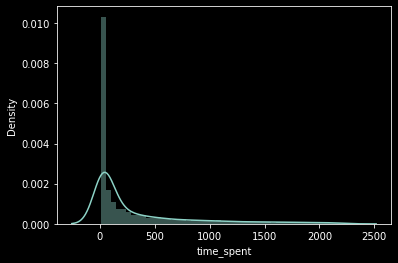

In [46]:
_ = sns.distplot(df_train_copy.time_spent)

In [50]:
print(df_train.shape[0], df_train_copy.shape[0])

5049 5049


In [48]:
df_train = df_train[(df_train['time_spent'] < upper_lim)]

## Utils

In [18]:
festive = '''1 Jan 2019
21 Mar 2019
15 Aug 2019
08 Oct 2019
27 Oct 2019
25 Dec 2019
29 Dec 2020
1 Jan 2020
10 Mar 2020
15 Aug 2020
25 Oct 2020
14 Nov 2020
25 Dec 2020
29 Dec 2020
'''

import datetime 

# t['Date'].to_pydatetime().date()
# t[['Date','Holiday']][t['Holiday']==True].head()

festive_list = []
range_list = []
for date in festive.splitlines():
    day, month_year = date.split(' ',1)
    range_list = [str(day)+' '+month_year for day in range(int(day)-2,int(day)+1) if int(day)>2]
    for date_range in range_list:
        date = datetime.datetime.strptime(date_range, '%d %b %Y') 
        if date.date() not in festive_list:
            festive_list.append(date.date())
            
def date_features(t, datecol):
    t[datecol+'Year'] = t[datecol].dt.year
    t[datecol+'Month'] = t[datecol].dt.month
    t['Day_of_week'] = t[datecol].dt.dayofweek
    t[datecol+'Day'] = t[datecol].dt.day
    t[datecol+'DayOfyear'] = t[datecol].dt.dayofyear
    t['Week'] = pd.to_datetime(t[datecol]).dt.week 
    t['Quarter'] = pd.to_datetime(t[datecol]).dt.quarter
    t['Is_year_start'] = t[datecol].dt.is_year_start
    t['Is_year_end'] = t[datecol].dt.is_year_end
    t['Is_month_start'] = np.where(pd.to_datetime(t[datecol]).dt.is_month_start,1,0) 
    t['Is_month_end'] = np.where(pd.to_datetime(t[datecol]).dt.is_month_end,1,0)
    t['Is_weekday'] = np.where(t['Day_of_week'].isin([0,1,2,3,4]),1,0)
    t['Is_Holiday'] = np.where(t[datecol].isin(festive_list),1,0)
    del t[datecol]
    return t 

# def device_details(x):
#     if 'iPhone' in x:
#         return 'IPhone'
#     elif 'Android' in x:
#         return 'Android'
#     elif 'Desktop' in x:
#         return 'Desktop'
#     elif 'iPad' in x:
#         return 'iPad'
#     else:
#         return 'Other'

def client_agent(x):
    if 'iPhone' in str(x):
            return 'IPhone'
    elif 'Windows' in str(x):
        return 'Windows'
    elif 'Mac OS X' in str(x):
        return 'Mac'
    elif 'Android' in str(x):
        return 'Android'
    elif 'Linux' in str(x):
        return 'Linux'
    else:
        return 'Other'

# def mergedevice(x):
#     if x['client_agent']!=x['device_details']:
#         return x['client_agent']+x['device_details']
#     return x['client_agent']

## FE

In [51]:
t = pd.concat([df_train.drop('time_spent', axis=1), df_test], ignore_index=True)

In [52]:
t.head()

,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out
0,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0
1,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0
2,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0
3,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0
4,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0


In [53]:
t[['device','browser']] = t['device_details'].str.split('-', expand=True)
t.drop(['device_details'], axis=1, inplace=True)

In [54]:
t['date'] = pd.to_datetime(t['date'])

In [55]:
t['pur_addedincart'] = t['purchased'] & t['added_in_cart']
t['checkout_addedincart'] = t['checked_out'] & t['purchased']
t['pur_addedincart_checkout'] = t['purchased'] & t['added_in_cart'] & t['checked_out'] 

In [56]:
t = date_features(t,'date')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [57]:
#t.device_details = t.device_details.apply(device_details)
t.client_agent = t.client_agent.apply(client_agent)

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(t.client_agent.value_counts())

In [ ]:
# t['device'] = t.apply(mergedevice, axis=1)

In [26]:
t.head()

,session_number,client_agent,purchased,added_in_cart,checked_out,device,browser,pur_addedincart,checkout_addedincart,pur_addedincart_checkout,dateYear,dateMonth,Day_of_week,dateDay,dateDayOfyear,Week,Quarter,Is_year_start,Is_year_end,Is_month_start,Is_month_end,Is_weekday,Is_Holiday
0,715,Windows,1,0,0,Desktop,Chrome,0,0,0,2020,1,2,22,22,4,1,False,False,0,0,1,0
1,55,IPhone,1,0,0,iPhone,iOS,0,0,0,2020,2,3,27,58,9,1,False,False,0,0,1,0
2,11,IPhone,0,0,0,iPhone,MobileWeb,0,0,0,2019,8,3,1,213,31,3,False,False,1,0,1,0
3,2794,Windows,0,1,0,Desktop,IE,0,0,0,2019,12,0,30,364,1,4,False,False,0,0,1,0
4,3674,IPhone,0,0,0,iPhone,Web,0,0,0,2019,9,1,10,253,37,3,False,False,0,0,1,0


In [ ]:
####### GROUPING FEATURES ########

grouped = t.groupby(['session_number']).agg({'purchased': ['nunique'],
                                        'device': ['nunique'], 
                                        'pur_addedincart_checkout': ['nunique'],
                                        'checked_out': ['nunique'],
                                        'added_in_cart': ['nunique'],
                                        })
grouped.columns = ['grpbysession_number' + '_'.join(c).strip('_') for c in grouped.columns]
t = pd.merge(t, grouped, on = ['session_number'], how='left')

In [41]:
t.head()

,session_number,client_agent,purchased,added_in_cart,checked_out,device,browser,pur_addedincart,checkout_addedincart,pur_addedincart_checkout,dateYear,dateMonth,Day_of_week,dateDay,dateDayOfyear,Week,Quarter,Is_year_start,Is_year_end,Is_month_start,Is_month_end,Is_weekday,Is_Holiday
0,715,Windows,1,0,0,Desktop,Chrome,0,0,0,2020,1,2,22,22,4,1,False,False,0,0,1,0
1,55,IPhone,1,0,0,iPhone,iOS,0,0,0,2020,2,3,27,58,9,1,False,False,0,0,1,0
2,11,IPhone,0,0,0,iPhone,MobileWeb,0,0,0,2019,8,3,1,213,31,3,False,False,1,0,1,0
3,2794,Windows,0,1,0,Desktop,IE,0,0,0,2019,12,0,30,364,1,4,False,False,0,0,1,0
4,3674,IPhone,0,0,0,iPhone,Web,0,0,0,2019,9,1,10,253,37,3,False,False,0,0,1,0


### Encoding

In [58]:
encode_cols = ['client_agent','device','browser','Is_year_start','Is_year_end']

In [59]:
from sklearn.preprocessing import LabelEncoder
t[encode_cols] = t[encode_cols].apply(LabelEncoder().fit_transform)

In [60]:
t.head()

,session_number,client_agent,purchased,added_in_cart,checked_out,device,browser,pur_addedincart,checkout_addedincart,pur_addedincart_checkout,dateYear,dateMonth,Day_of_week,dateDay,dateDayOfyear,Week,Quarter,Is_year_start,Is_year_end,Is_month_start,Is_month_end,Is_weekday,Is_Holiday
0,715,5,1,0,0,2,1,0,0,0,2020,1,2,22,22,4,1,0,0,0,0,1,0
1,55,1,1,0,0,6,8,0,0,0,2020,2,3,27,58,9,1,0,0,0,0,1,0
2,11,1,0,0,0,6,4,0,0,0,2019,8,3,1,213,31,3,0,0,1,0,1,0
3,2794,5,0,1,0,2,3,0,0,0,2019,12,0,30,364,1,4,0,0,0,0,1,0
4,3674,1,0,0,0,6,7,0,0,0,2019,9,1,10,253,37,3,0,0,0,0,1,0


## Split back

In [61]:
trn = t[:df_train.shape[0]]
tst = t[df_train.shape[0]:]
y = df_train.time_spent

In [62]:
trn = trn.reset_index(drop=True)
tst = tst.reset_index(drop=True)
y = y.reset_index(drop=True)

In [63]:
print(trn.shape, y.shape, tst.shape)

(5049, 23) (5049,) (2327, 23)


In [64]:
trncopy = pd.concat([trn, y], axis=1)

## Post FE EDA

In [35]:
trncopy.head(2)

,session_number,client_agent,purchased,added_in_cart,checked_out,device,browser,pur_addedincart,checkout_addedincart,pur_addedincart_checkout,dateYear,dateMonth,Day_of_week,dateDay,dateDayOfyear,Week,Quarter,Is_year_start,Is_year_end,Is_month_start,Is_month_end,Is_weekday,Is_Holiday,time_spent
0,715,5,1,0,0,2,1,0,0,0,2020,1,2,22,22,4,1,0,0,0,0,1,0,236.886
1,55,1,1,0,0,6,8,0,0,0,2020,2,3,27,58,9,1,0,0,0,0,1,0,1277.455


In [36]:
# cat_feats = ['client_agent','device_details','purchased','added_in_cart','checked_out','pur_addedincart']
cat_feats = [col for col in trncopy.columns if trncopy[col].nunique()<=20]
num_feats = [col for col in trncopy.columns if trncopy[col].nunique()>20 and col!='time_spent']

In [37]:
print(len(cat_feats), len(num_feats))

19 4


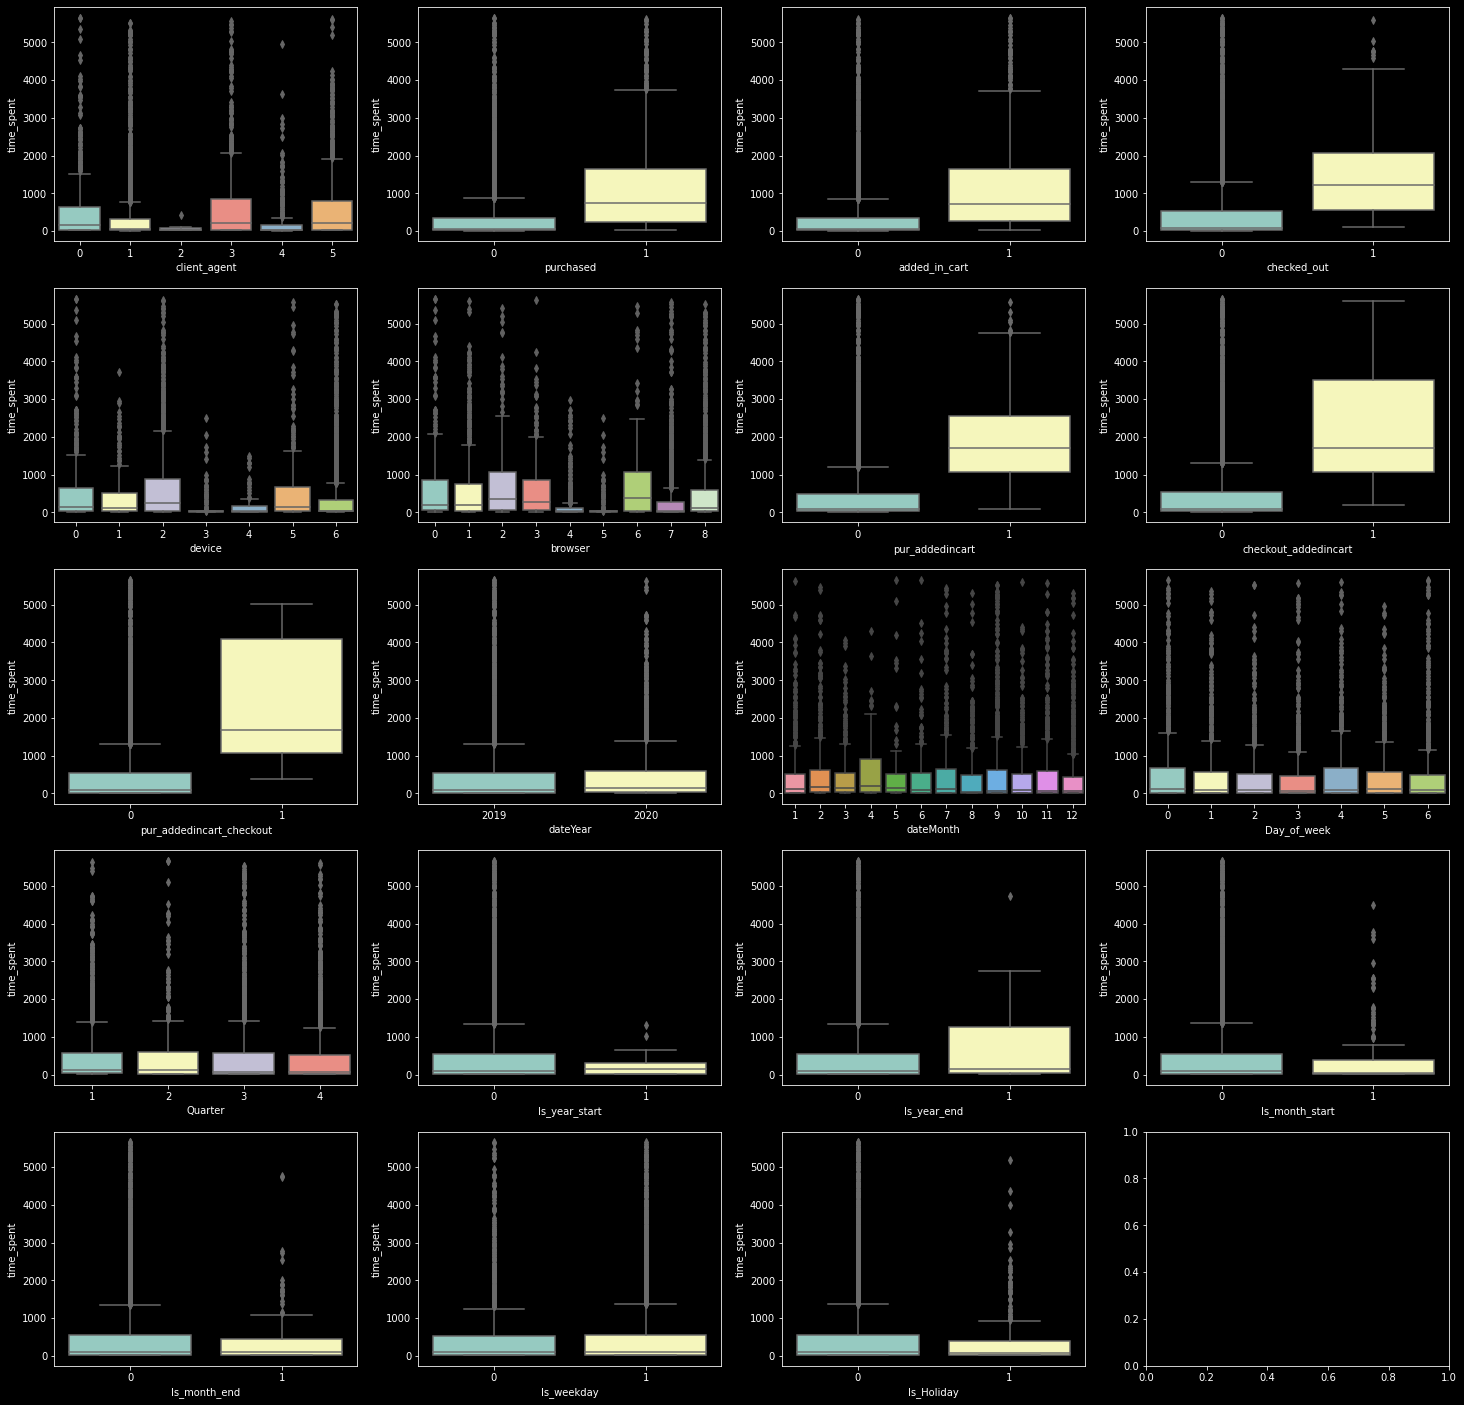

In [38]:
fig, ax = plt.subplots(5, 4, figsize=(25, 25))

for catfeat, subplot in zip(cat_feats, ax.flatten()):
    sns.boxplot(x=catfeat, y='time_spent', data=trncopy, ax=subplot)

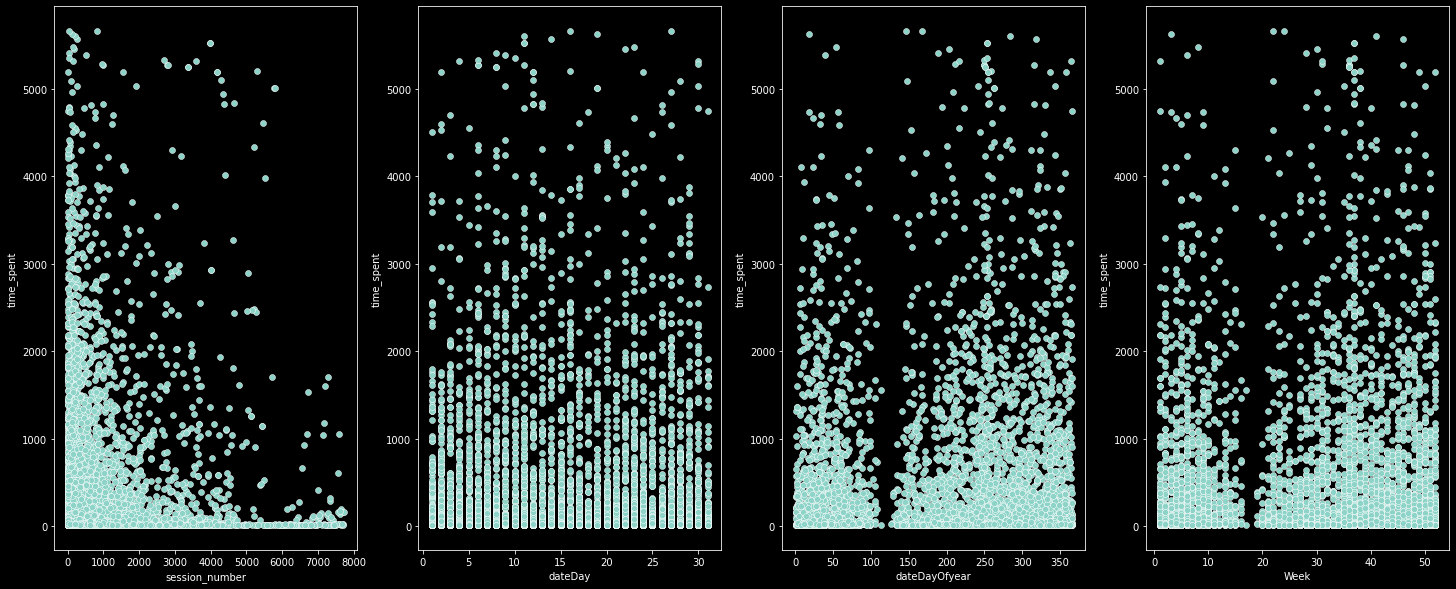

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(25, 10))

for numfeat, subplot in zip(num_feats, ax.flatten()):
    sns.scatterplot(x=numfeat, y='time_spent', data=trncopy, ax=subplot)

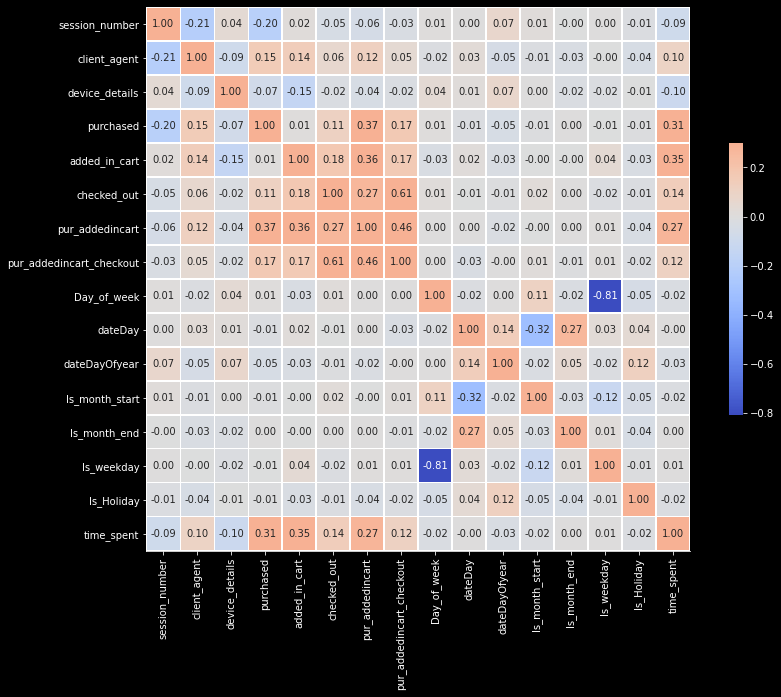

In [ ]:
corr = trncopy.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()

In [ ]:
df=pps.matrix(trncopy)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots(figsize=(10,10)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

### Drop cols

In [ ]:
trn.drop(['dateDay','dateDayOfyear'], axis=1, inplace=True)
tst.drop(['dateDay','dateDayOfyear'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Baseline

In [40]:
def kfold_cv(trn, target, estimator_name, estimator, n_splits=5, shuffle_val=False, featimp=False):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    if shuffle_val:
        kfold, scores = KFold(n_splits=splits,shuffle=shuffle_val), list()
    else:
        kfold, scores = KFold(n_splits=splits, shuffle=shuffle_val, random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)

        if featimp:
            feature_importances = pd.DataFrame(model.feature_importances_,
                                            index = trn.columns,
                                            columns=['importance'])
            featimp_list.append(feature_importances.values)

        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        #print("RMSLE Score is", score)

    print(f"Average of model {estimator_name} is {np.sum(scores)/len(scores)} and per fold scores are {scores}")
    if featimp:
        for item in featimp_list:
            add+=item
        df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
        display(df_cv)

## Baseline Test

In [65]:
baseline_models = {
    "SVR" : SVR(),
    "rfreg" : RandomForestRegressor(n_jobs=-1),
    "lgb" : LGBMRegressor(n_estimators=50),
    'xgb' : XGBRegressor(objective ='reg:squarederror',n_estimators=50),
    'extratrees' : ExtraTreesRegressor(n_jobs=-1),
    'DTReg' : DecisionTreeRegressor(),
    "KNN Reg" : KNeighborsRegressor(),
    "CB REg" : CatBoostRegressor(verbose=False),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet":ElasticNet(random_state=0),
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

In [ ]:
# for model_name, model in baseline_models.items():
#     kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)

Average of model SVR is 1.7364158181169398 and per fold scores are [1.746164842156626, 1.6866683689940352, 1.7451360549783608, 1.7489208241938732, 1.755189000261804]
Average of model rfreg is 1.4247806927407733 and per fold scores are [1.3863628054662716, 1.4402008825109471, 1.441303223900409, 1.4249740874801953, 1.4310624643460437]
Average of model lgb is 1.3596583496184724 and per fold scores are [1.3334779306343345, 1.3937750709631465, 1.4064532699621997, 1.3420042420565987, 1.3225812344760821]
Average of model xgb is 1.3733561148711093 and per fold scores are [1.3640717564466958, 1.3634398065360105, 1.3463301693546739, 1.3722550266979168, 1.4206838153202501]
Average of model extratrees is 1.5501789907598769 and per fold scores are [1.53550274455772, 1.5173222501449375, 1.5292168895290466, 1.588493735273496, 1.5803593342941842]
Average of model DTReg is 1.8729162761166471 and per fold scores are [1.8545091383378784, 1.8370917778923086, 1.8993410961530852, 1.8232221415647254, 1.95041

In [ ]:
# ## After percentile Outlier removal
# for model_name, model in baseline_models.items():
#     kfold_cv(trn, y, model_name, model, n_splits=10, shuffle_val=True)

Average of model SVR is 1.4735370184957397 and per fold scores are [1.493518212456112, 1.4596458844717064, 1.4269047923237344, 1.446478259278025, 1.5090773692754353, 1.4882947302168905, 1.5095654253806092, 1.4315853788491584, 1.5070418704222872, 1.4632582622834382]
Average of model rfreg is 1.2324749339701113 and per fold scores are [1.3411356137792496, 1.3018898670256611, 1.1654813170348137, 1.1833473284689808, 1.1991695814193695, 1.1693974064976802, 1.2529560875789632, 1.2251997790251223, 1.256985250237284, 1.2291871086339887]
Average of model lgb is 1.1742088621975004 and per fold scores are [1.1892094134450062, 1.2397701354236663, 1.0910438210922553, 1.1572073971264392, 1.2138389680838733, 1.1841771854720389, 1.1858212228295466, 1.1572603820504228, 1.1563221680724707, 1.1674379283792857]
Average of model xgb is 1.1796110892430847 and per fold scores are [1.1614261007659767, 1.1663293449839292, 1.1924549033310667, 1.1678058951331085, 1.2026710825061602, 1.1609613674539596, 1.1804833

In [66]:
for model_name, model in baseline_models.items():
    kfold_cv(trn, y, model_name, model, n_splits=10, shuffle_val=True)

Average of model SVR is 1.5790166617903407 and per fold scores are [1.6288372964208162, 1.6018750750943809, 1.5175421145173187, 1.6154205897473788, 1.5563831466880698, 1.5476953514235148, 1.5950079434317994, 1.6060970824513905, 1.5763775175098729, 1.544930500618866]
Average of model rfreg is 1.2837668320362092 and per fold scores are [1.2931916859168948, 1.3002614076652066, 1.3021885563051347, 1.2937653870603303, 1.2419651090040005, 1.2846877166525439, 1.2269063772689508, 1.2858347711290286, 1.3109113773894419, 1.2979559319705603]
Average of model lgb is 1.2189032762890355 and per fold scores are [1.272722316011747, 1.2150271902985008, 1.2301340872440054, 1.226963088147114, 1.2060581764611156, 1.226467186720422, 1.14306299732379, 1.3212945480413965, 1.1828498076719762, 1.1644533649702866]
Average of model xgb is 1.2266804997952554 and per fold scores are [1.2882593422367643, 1.1720699276430357, 1.196897585746722, 1.1720376284368341, 1.2416832629770829, 1.241313271128272, 1.265279704538

## Stacking models

In [ ]:
%%time

model = StackingRegressor([('cb',CatBoostRegressor(verbose=False)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
$model = StackingRegressor([('gbr':GradientBoostingRegressor(random_state=0)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model_name  = 'Stacking Reg'
kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)

Average of model Stacking Reg is 1.3583689111184225 and per fold scores are [1.3429893072239478, 1.3637663286298805, 1.3707918509871677, 1.34662979176539, 1.3676672769857259]
CPU times: user 339 ms, sys: 397 ms, total: 736 ms
Wall time: 1min 27s


In [ ]:
%%time

# model = StackingRegressor([('cb',CatBoostRegressor(verbose=False)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model = StackingRegressor([('gbr',GradientBoostingRegressor(random_state=0)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model_name  = 'Stacking Reg'
kfold_cv(trn, y, model_name, model, n_splits=5, shuffle_val=True)

Average of model Stacking Reg is 1.174397435979272 and per fold scores are [1.1365734774487797, 1.1920861866837564, 1.168084242036888, 1.2124275854697537, 1.1628156882571825]
CPU times: user 314 ms, sys: 439 ms, total: 753 ms
Wall time: 18.4 s


In [ ]:
%%time

# model = StackingRegressor([('cb',CatBoostRegressor(verbose=False)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model = StackingRegressor([('gbr',GradientBoostingRegressor(random_state=0)), ('lgb',  LGBMRegressor(n_estimators=50)),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)
model_name  = 'Stacking Reg'
kfold_cv(trn, y, model_name, model, n_splits=10, shuffle_val=True)

Average of model Stacking Reg is 1.1729403110529337 and per fold scores are [1.2006459727362384, 1.1502108022796353, 1.158941486843467, 1.2037044827167485, 1.183649784749836, 1.1208287329626034, 1.166720279887072, 1.199153359922715, 1.198295895452365, 1.1472523129786556]
CPU times: user 618 ms, sys: 857 ms, total: 1.48 s
Wall time: 38.8 s


## HypOpt

In [67]:
def RMSLE(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

rmsle = make_scorer(RMSLE, greater_is_better=False)

In [ ]:
#Hyperparameter tuning of LightGBM Regressor using Bayesian optimization

def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, targets):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves = num_leaves,
        min_child_samples=min_child_samples,
        subsample = subsample,
        random_state = 2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmsle, cv=5)
    return cval.mean()

def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves = int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators": (10,200),
            "num_leaves": (2,30),
            "min_child_samples": (2,30),
            "subsample": (0.1,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=5, init_points=20)

    print("Final result:", optimizer.max)

In [ ]:
optimize_lgb(trn, np.log1p(y))

|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -1.178    |  7.363    |  128.2    |  14.26    |  0.8068   |
|  2        | -1.172    |  23.84    |  61.79    |  9.741    |  0.8217   |
|  3        | -1.179    |  28.83    |  176.4    |  12.02    |  0.5509   |
|  4        | -1.178    |  21.14    |  145.4    |  12.37    |  0.6051   |
|  5        | -1.201    |  16.09    |  12.62    |  23.64    |  0.8944   |
|  6        | -1.179    |  12.22    |  126.9    |  4.111    |  0.4319   |
|  7        | -1.178    |  28.13    |  133.8    |  13.12    |  0.8099   |
|  8        | -1.19     |  10.87    |  117.9    |  26.34    |  0.4926   |
|  9        | -1.173    |  24.46    |  37.32    |  21.72    |  0.7341   |
|  10       | -1.185    |  8.126    |  185.7    |  14.38    |  0.9184   |
|  11       | -1.194    |  3.675    |  45.01    |  3.326    |  0.7074   |
|  12       | -1.181    |  18.65    | 

In [ ]:
lgbopt = LGBMRegressor(min_child_samples=24,
            n_estimators=62,
            num_leaves=10,
            subsample= 0.82168495)

### RF Hypopt

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 50, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 34, 48, 63, 77, 92, 106, 121, 135, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 6, 11, 16, 21, 26, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestRegressor()
target - y

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(trn, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 135}

## Inference

In [ ]:
def kfold_opt_cv(trn, target, test_set, estimator, n_splits=5, shuffle_val=False, featimp=False):
    featimp_list = []
    add = 0
    splits = n_splits
    target = np.log1p(target)
    oof_pred = oof_preds = np.zeros(len(test_set))
    if shuffle_val:
        kfold, scores = KFold(n_splits=splits,shuffle=shuffle_val), list()
    else:
        kfold, scores = KFold(n_splits=splits,random_state=42), list()
    for train, test in kfold.split(trn,target):
        x_train, x_test = trn.values[train], trn.values[test]
        y_train, y_test = target.values[train], target.values[test]
        model = estimator
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        preds = np.expm1(preds)
        oof_pred = model.predict(test_set)
        oof_preds += np.expm1(oof_pred)

        if featimp:
            feature_importances = pd.DataFrame(model.feature_importances_,
                                            index = trn.columns,
                                            columns=['importance'])
            featimp_list.append(feature_importances.values)

        score = np.sqrt(mean_squared_log_error(np.expm1(y_test), preds))
        scores.append(score)
        print("Score is", score)

    oof_preds = oof_preds/splits
    print("Average:", np.sum(scores)/len(scores))
    if featimp:
        for item in featimp_list:
            add+=item
        df_cv=pd.DataFrame(add/len(featimp_list),index=trn.columns,columns=["importance"]).sort_values('importance', ascending=False)
        display(df_cv)
    return oof_preds

In [ ]:
sub_model = StackingRegressor([('gbr',GradientBoostingRegressor(random_state=0)), ('lgb', lgbopt),('xgb',XGBRegressor(objective ='reg:squarederror',n_estimators=50))],n_jobs=-1)

In [ ]:
preds = kfold_opt_cv(trn, y, tst.values, sub_model, 10, shuffle_val=True)

Score is 1.1518868743826558
Score is 1.1895287003600694
Score is 1.198922222387138
Score is 1.1552071270756246
Score is 1.1403463059087888
Score is 1.2090469528905547
Score is 1.1760971298032523
Score is 1.1442312664396352
Score is 1.1470515643898591
Score is 1.2313527798335793
Average: 1.1743670923471157


## Submission

In [ ]:
#np.set_printoptions(threshold=np.inf)
preds

array([386.87809219,  80.07334781, 283.07121105, ...,  54.20085717,
       256.03218886, 366.62549053])

In [ ]:
sub.time_spent = preds
sub.head()

,time_spent
0,386.878092
1,80.073348
2,283.071211
3,98.820096
4,85.519389


In [ ]:
sub.to_csv('stacked_model_grp_1.csv', index=False)

In [ ]:
from google.colab import files
files.download("stacked_model_grp_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>